In [1]:
import os
import re
import sys

import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics as skmetrics
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.font_manager import fontManager
from IPython.display import display
from ipywidgets import interact, FloatSlider
from umap import UMAP
import ipynbname
from endaaman.ml import fix_global_seed

fix_global_seed()

project_root = os.path.abspath(os.path.join(os.path.dirname(ipynbname.path()), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
os.chdir(project_root)
print('now working', project_root)


sns.set_theme(style='ticks', palette='tab10')
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 16,
    'figure.dpi': 300,
})

os.makedirs('out/figs', exist_ok=True)

now working /home/ken/src/github.com/endaaman/bt


In [2]:
import random
import colorcet as cc

labels = [
    'Prov-GigaPath(LP)',
    'UNI(FT)',
    'UNI(LP)',
    'CTransPath(FT)',
    'CTransPath(LP)',
    r'ViT-L$\mathrm{_{IN}}$(FT)',
    r'ViT-L$\mathrm{_{IN}}$(LP)',
    r'ViT-L(RI)',
    r'ResNet-RS 50$\mathrm{_{IN}}$(FT)',
    r'ResNet-RS 50$\mathrm{_{IN}}$(LP)',
    r'ResNet-RS 50(RI)',
]
print(len(labels))
# colors = sns.color_palette('pastel20', len(label))
colors = sns.color_palette(cc.glasbey_hv, n_colors=len(labels))
color_map = dict(zip(labels, colors))
display(colors)

11


[(0.188235, 0.635294, 0.854902),
 (0.988235, 0.309804, 0.188235),
 (0.898039, 0.682353, 0.219608),
 (0.427451, 0.564706, 0.309804),
 (0.545098, 0.545098, 0.545098),
 (0.090196, 0.745098, 0.811765),
 (0.580392, 0.403922, 0.741176),
 (0.839216, 0.152941, 0.156863),
 (0.121569, 0.466667, 0.705882),
 (0.890196, 0.466667, 0.760784),
 (0.54902, 0.337255, 0.294118)]

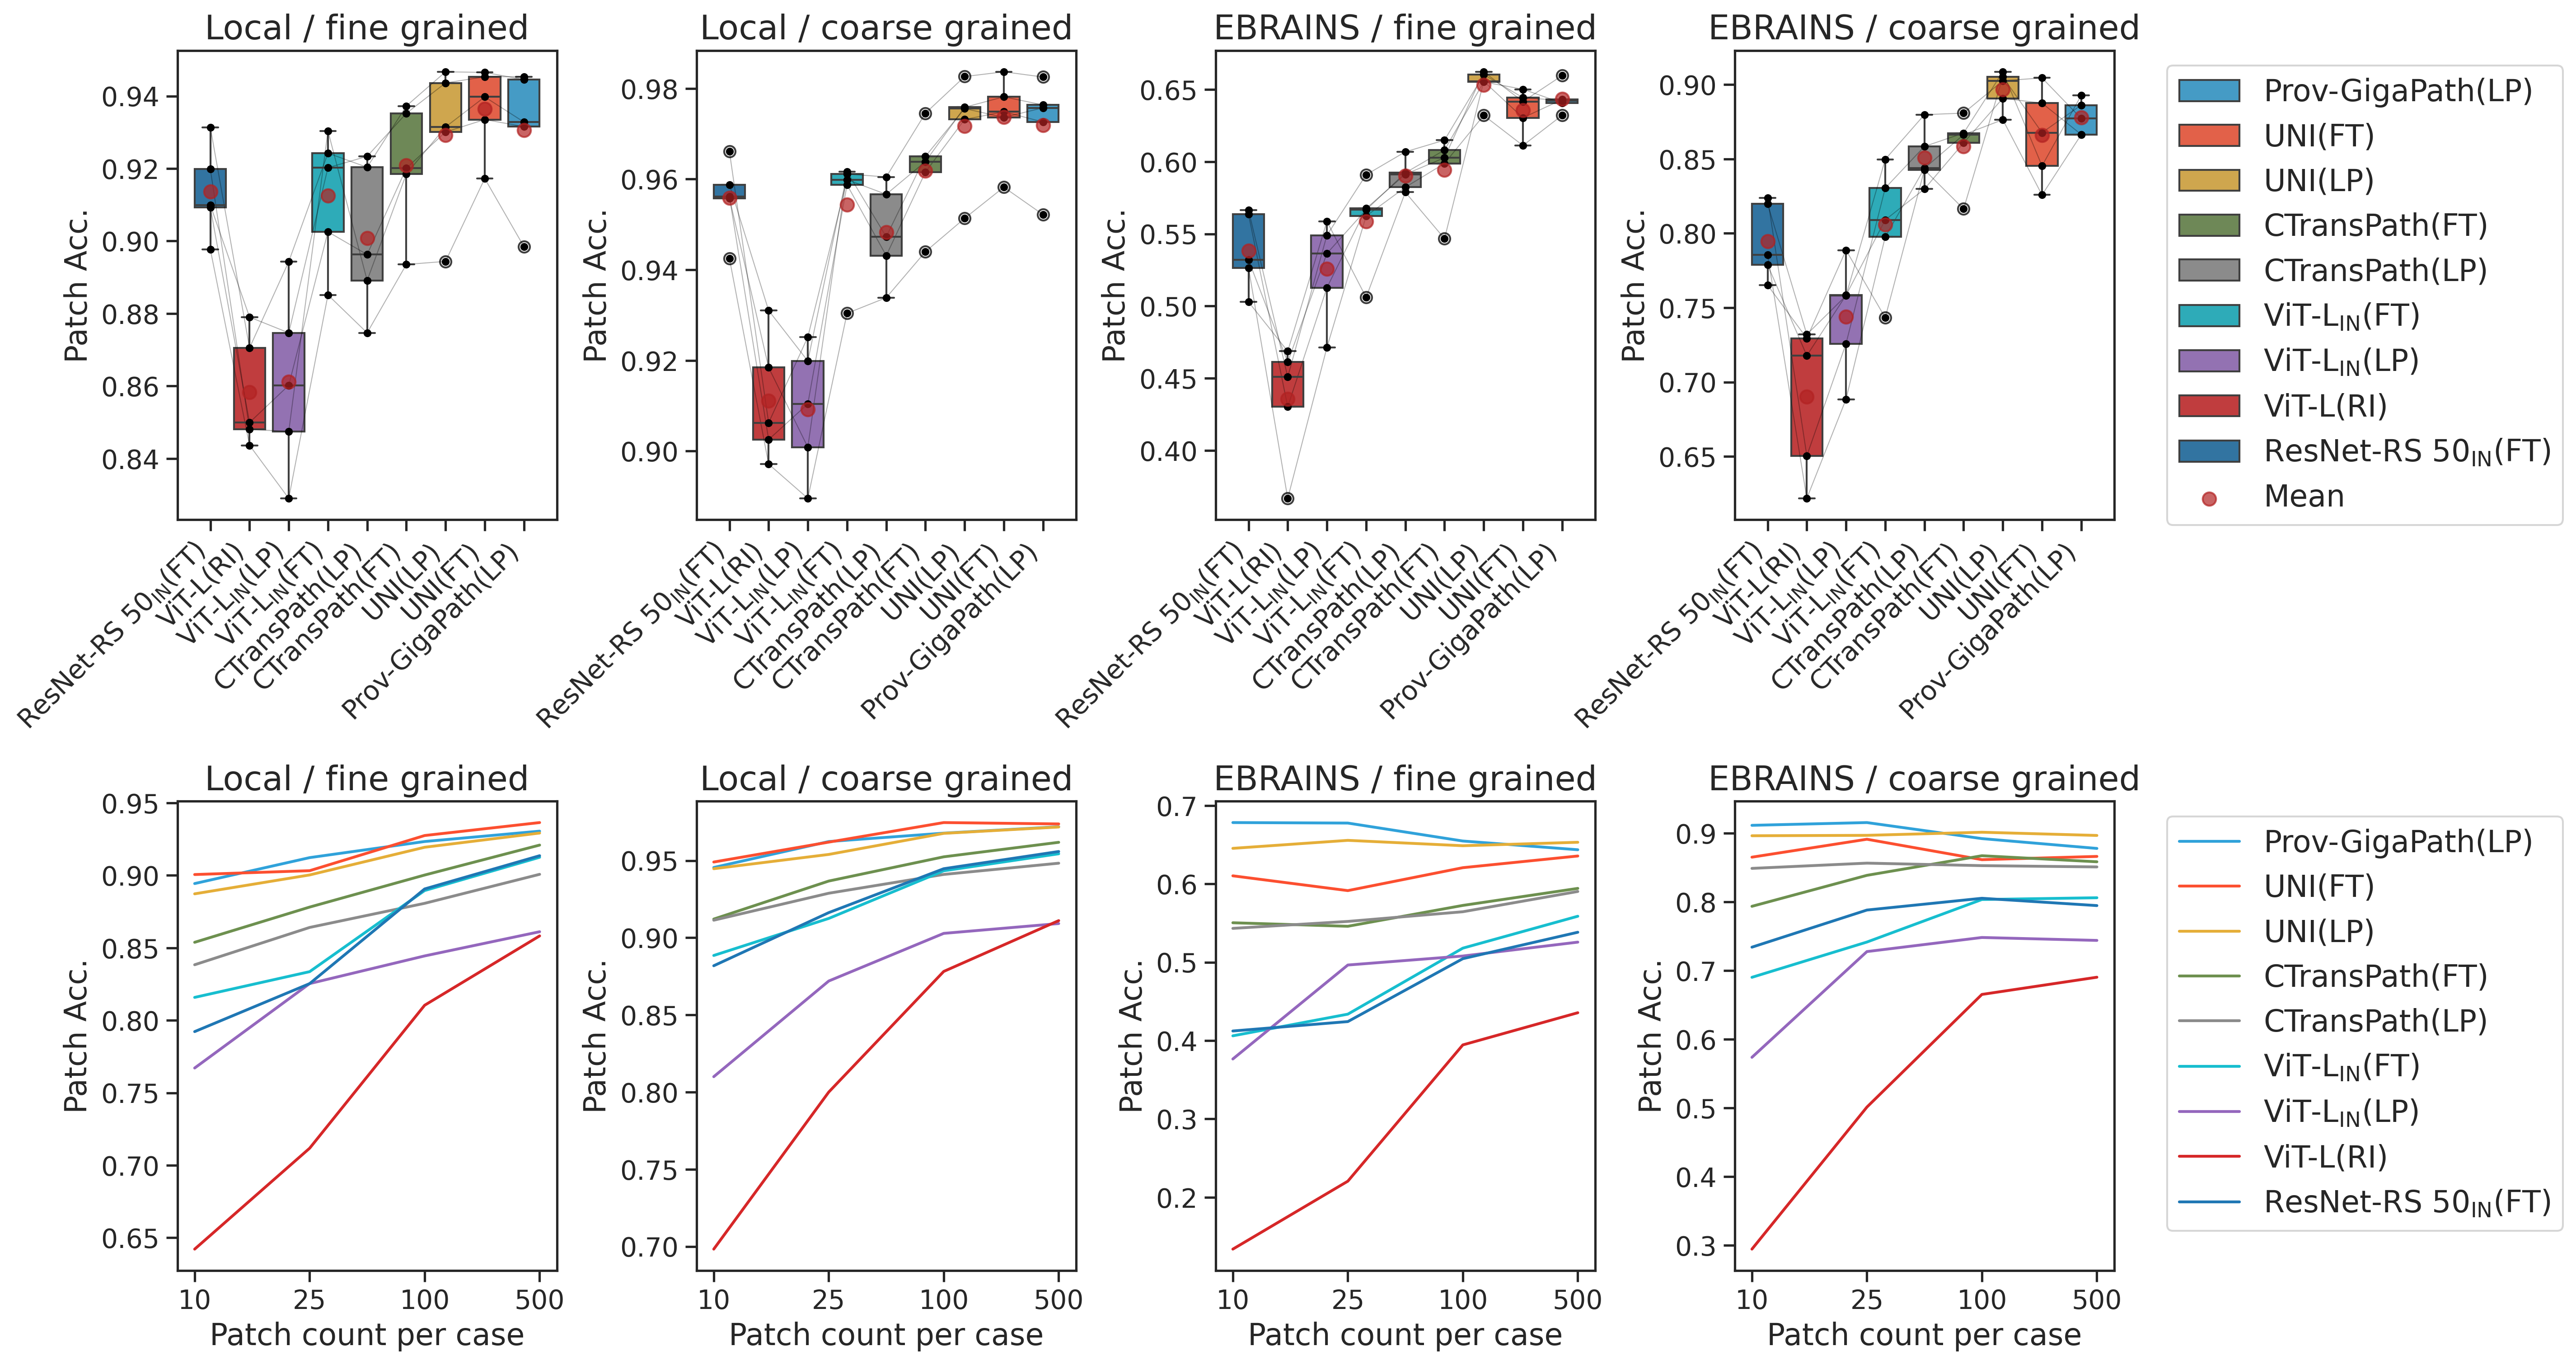

In [3]:
from datasets.ebrains import get_ebrains_df


limit = 500

labels = [
    r'Prov-GigaPath(LP)',
    r'UNI(FT)',
    r'UNI(LP)',
    r'CTransPath(FT)',
    r'CTransPath(LP)',
    r'ViT-L$\mathrm{_{IN}}$(FT)',
    r'ViT-L$\mathrm{_{IN}}$(LP)',
    r'ViT-L(RI)',
    r'ResNet-RS 50$\mathrm{_{IN}}$(FT)',    
]


key = 'pacc'
recipes = [
    ['cv', 'fine'],
    ['cv', 'coarse'],
    ['ebrains', 'fine'],
    ['ebrains', 'coarse'],
]

key_map = {
    'pacc': 'Patch Acc.',
    'recall': 'Macro Recall',
    'acc': 'Macro Acc.',
    'f1': 'Macro F1',
}


fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(
    2, 5, width_ratios=[1, 1, 1, 1, 0.6],
    top = 0.95,  
    bottom = 0.05,
    right = 0.95,
    left = 0.1,
    wspace = 0.4,
    hspace = 0.6,
)


axes = [
    fig.add_subplot(gs[0]),
    fig.add_subplot(gs[1]),
    fig.add_subplot(gs[2]),
    fig.add_subplot(gs[3]),
]

for i, ((target, grains), ax) in enumerate(zip(recipes, axes)):
    key_label = key_map[key]    
    df = pd.read_excel(f'out/figs/tables/results_{grains}_{target}.xlsx', sheet_name=f'{limit}', index_col=0)    
    df = df[df['label'].isin(labels)]

    n_folds, n_models = 5, len(df)//5

    df_mean = df.groupby('cond')[key_label].mean().sort_values(ascending=True)
    df = df[::-1]    

    # Box plot
    sns.boxplot(x='label', 
                hue='label', 
                y=key_label, 
                data=df, 
                palette=[color_map[label] for label in labels[::-1]], 
                ax=ax, 
                legend=True if i == 3 else False)

    # Connect folds with lines
    for fold in range(n_folds):
        fold_data = df[df['fold'] == fold]
        ax.plot(range(n_models), fold_data[key_label], 'k-', alpha=0.3, linewidth=0.5)
    
    # Scatter individual points
    for i, label in enumerate(labels[::-1]):
        ax.scatter([i] * n_folds, df[df['label'] == label][key_label], color='black', s=10, zorder=3)
    
    mean_scatter = ax.scatter(
        labels, 
        [df[df['label'] == l][key_label].mean() for l in labels],
        color='firebrick', s=50, zorder=5, label='Mean', alpha=0.7)

    # Set ax1 properties
    target_dataset = {
        'cv': 'Local',
        'ebrains': 'EBRAINS',
    }[target]
    ax.set_xticks(range(len(labels[::-1])))
    ax.set_xticklabels(labels[::-1], rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel(key_label)
    ax.set_title(f'{target_dataset} / {grains} grained')

box_handles = ax.get_legend_handles_labels()[0][:-1][::-1]
legend_handles = box_handles + [mean_scatter]
legend_labels = labels + ['Mean']
ax.legend(legend_handles, legend_labels, bbox_to_anchor=(1.1, 1), loc='upper left')


axes = [
    fig.add_subplot(gs[5]),
    fig.add_subplot(gs[6]),
    fig.add_subplot(gs[7]),
    fig.add_subplot(gs[8]),
]

for i, ((target, grains), ax) in enumerate(zip(recipes, axes)):
    key_label = key_map[key]
    
    limits = [10, 25, 100, 500]
    alpha = 0.05
    
    values_by_limit = []

    for limit in limits:
        values = []
        df = pd.read_excel(f'out/figs/tables/results_{grains}_{target}.xlsx', sheet_name=f'{limit}', index_col=0)

        for label in labels:
            scores = df[df['label']==label][key_label]
            mean = np.mean(scores)
            diff = stats.sem(scores)
            values.append([mean, mean-diff, mean+diff])
        values_by_limit.append(values)    
    values_by_cond = np.array(values_by_limit).transpose(1, 0, 2)
    
    x = np.arange(1, 1+len(limits))

    for i, label in enumerate(labels):
        ci_l = values_by_cond[i, :, 1]
        ci_h = values_by_cond[i, :, 2]
        # c = colors[i]
        c = color_map[label]
        ax.plot(x, values_by_cond[i, :, 0], color=c, label=label)
    
    ax.set_xticks(x, limits)
    ax.set_xlabel('Patch count per case')
    ax.set_ylabel(key_label)
    target_dataset = {
        'cv': 'Local',
        'ebrains': 'EBRAINS',
    }[target]
    ax.set_title(f'{target_dataset} / {grains} grained')    

ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left')

# plt.tight_layout()
plt.savefig('out/figs/fig2/fig2_main.png', bbox_inches='tight')
plt.show()


              precision    recall  f1-score   support

           A       0.87      0.50      0.63        26
           G       0.85      0.97      0.91        66
           L       0.98      0.98      0.98        52
           M       0.99      0.99      0.99        81
           O       0.81      0.88      0.84        24

    accuracy                           0.92       249
   macro avg       0.90      0.86      0.87       249
weighted avg       0.92      0.92      0.91       249

              precision    recall  f1-score   support

           A       0.49      0.62      0.55       151
           G       0.77      0.74      0.76       265
           L       0.70      0.97      0.81        59
           M       0.68      0.96      0.80        47
           O       0.88      0.53      0.66       176

    accuracy                           0.69       698
   macro avg       0.70      0.76      0.71       698
weighted avg       0.72      0.69      0.69       698

wrote out/figs/fig2/fi

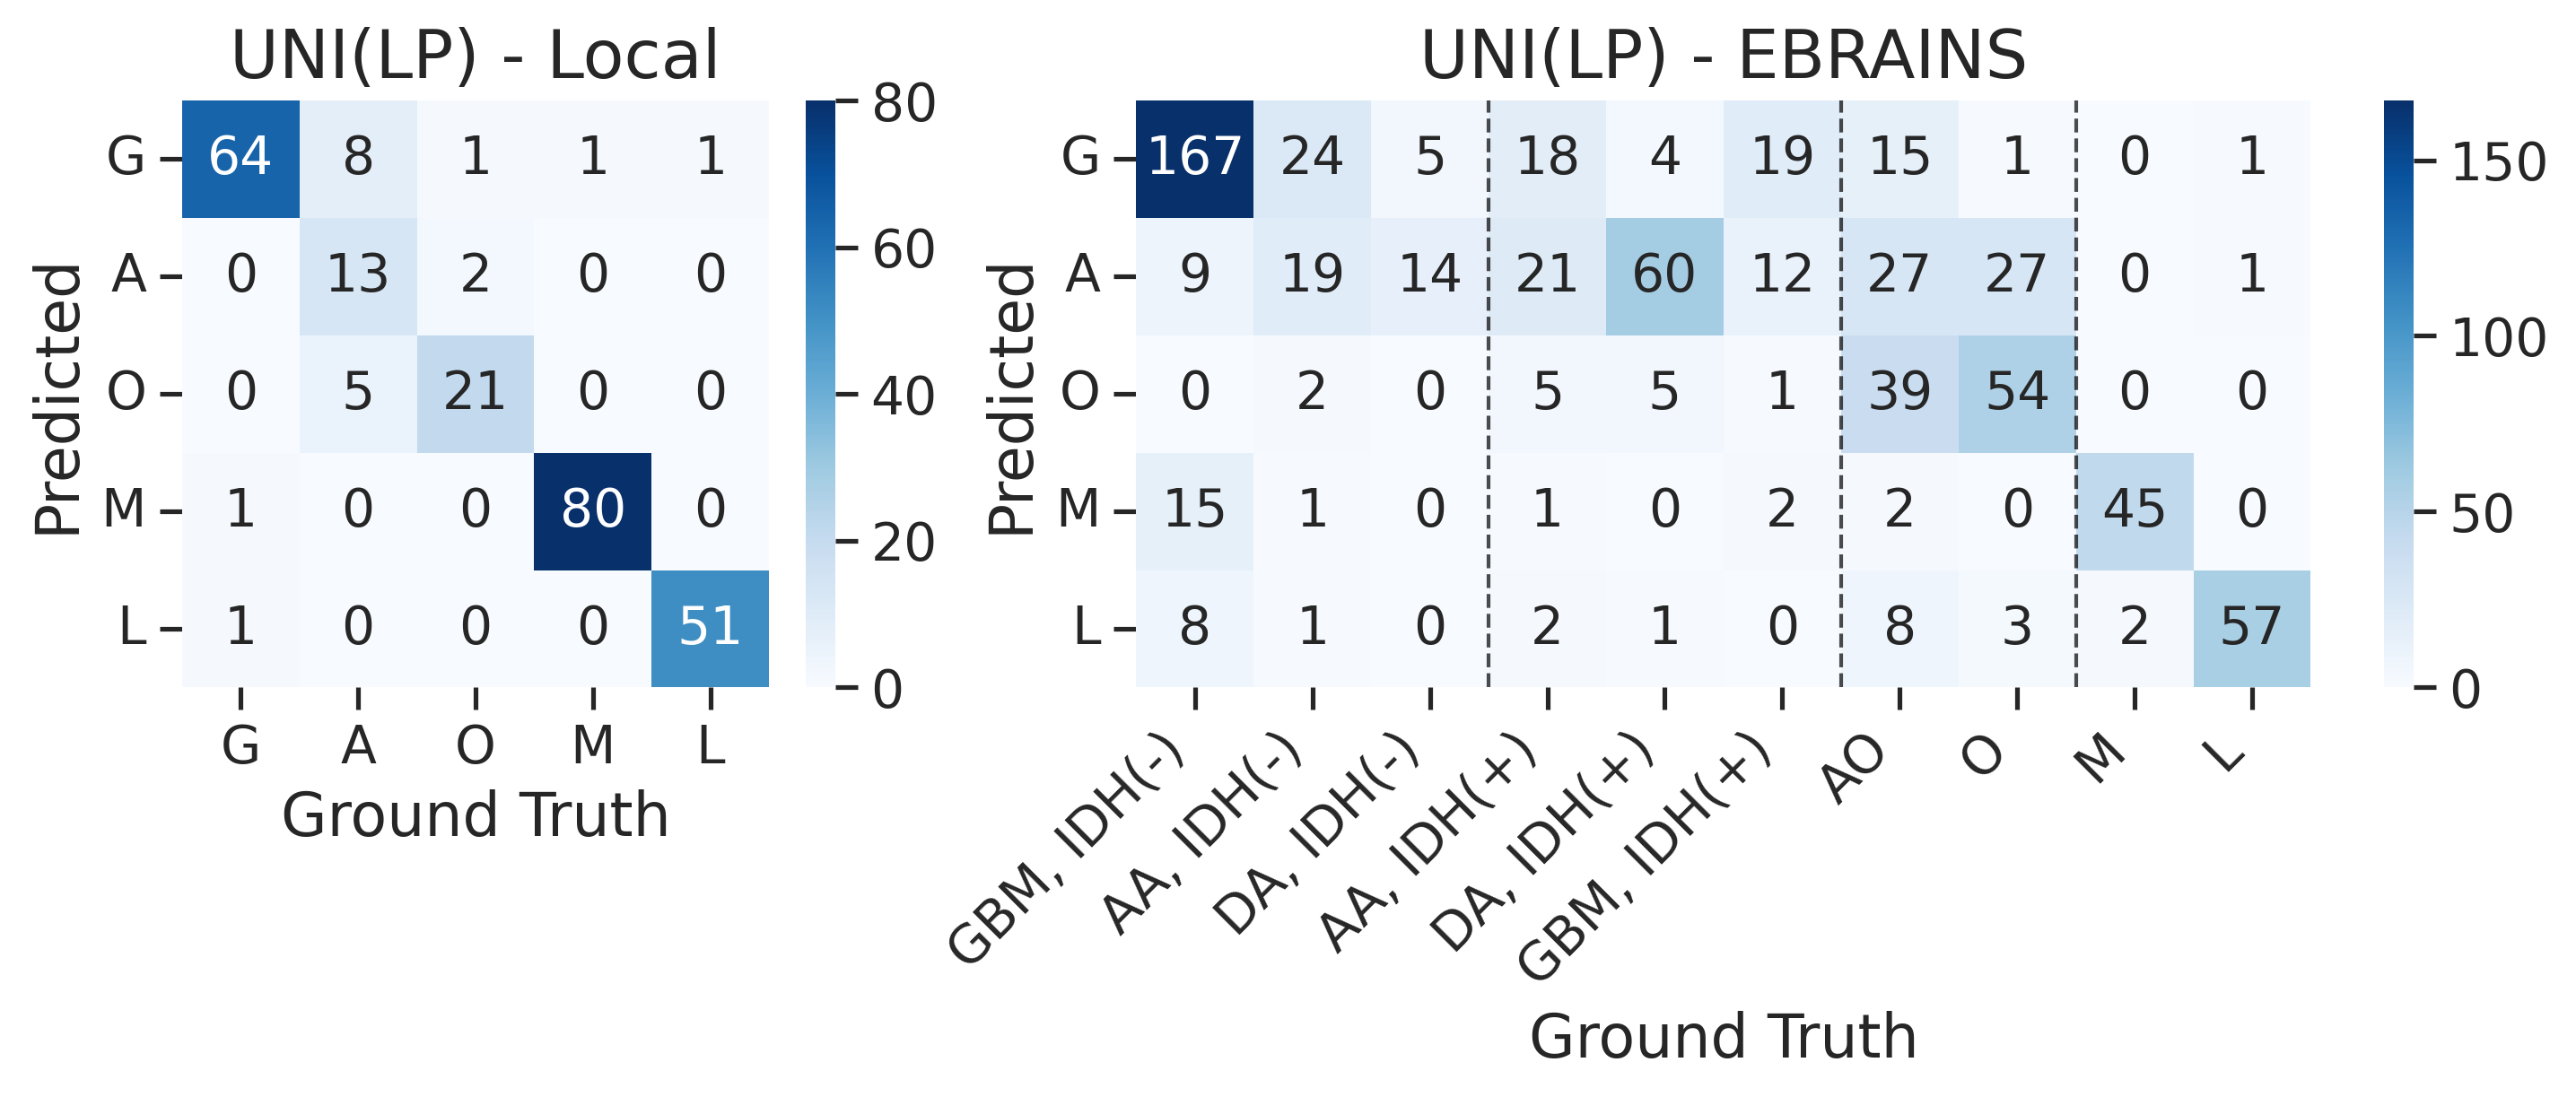

In [4]:
def draw_cm(base, encoder, limit=500, with_b=False):
    fig = plt.figure(figsize=(10, 6))
    gs = fig.add_gridspec(
        1, 2, width_ratios=[1, 2],
        top=0.95,           # Changed from 0.01 to 0.95 to reduce top margin
        bottom=0.05,        # Changed from 0.5 to 0.05 to reduce bottom margin
        right=0.95,         # Added right margin parameter
        left=0.05,          # Added left margin parameter
        wspace=0.2,        # Kept the same spacing between subplots
    )
                          
    rules = ((
        'cv', # target
        'Local', # target_label
        'diag_org',   # gy_key
        'pred(sum)',    # pred_key        
        'out/compare/LMGAOB/fold5_{fold}/{cond}/test/report.xlsx', # base_path            
        fig.add_subplot(gs[0]),
    ), (
        'ebrains', # target
        'EBRAINS', # target_label
        'label',   # gy_key
        'pred',    # pred_key        
        'out/compare/LMGAOB/fold5_{fold}/{cond}/ebrains.xlsx', # base_path            
        fig.add_subplot(gs[1]),
    ))
    for target, target_label, gt_key, pred_key, base_path, ax in rules:        
        mm = []
        for fold in range(5):
            cond = f'{encoder}_{base}_{limit}'
            # p = f'out/compare/LMGAOB/fold5_{fold}/{encoder}_{base}_{limit}/ebrains.xlsx'
            p = base_path.format(
                fold=fold,
                cond=cond,
            )
            df = pd.read_excel(p, 'cases', index_col=0)
            # drop B
            df = df[df[gt_key] != 'B']
            m = df[[gt_key]].rename(columns={gt_key: 'gt'}).copy()
            y_pred = []
            for i, row in df.iterrows():
                p = row[pred_key]
                if not with_b and p == 'B':
                    print('pred B', row[unique_code])
                    p = unique_code[row[unique_code].argsort().iloc[-2]]
                    print('select second', p)
                y_pred.append(p)
            m['pred'] = y_pred
            mm.append(m)
        labels = list('GAOML')
        if with_b:
            labels += ['B']
        df = pd.concat(mm)

        if target == 'ebrains':
            # if ebrains do ensemble
            df_map = get_ebrains_df()
            new_data = []
            for name, rows in df.groupby('name'):
                subtype = df_map.loc[name, 'subtype']

                counts = rows['pred'].value_counts()
                top_pred = counts[counts == counts.max()]
                if len(top_pred) == 1:
                    pred = counts.index[0]
                else:
                    # 同率一位
                    pred =top_pred.index[0]
                new_data.append({
                    'name': name,
                    'subtype': subtype,
                    'gt': rows.iloc[0]['gt'],
                    'pred': pred,
                })
            df = pd.DataFrame(new_data)

        cond = f'{encoder}_{base}'
        label = {
            'frozen_uni': 'UNI(LP)',
            'unfrozen_uni': 'UNI(FT)',
            'frozen_baseline-vit': r'ViT-L$\mathrm{_{IN}}$(LP)',
            'unfrozen_baseline-vit': r'ViT-L$\mathrm{_{IN}}$(FT)',
        }.get(cond, cond)
        label = f'{label} - {target_label}'

        if target == 'ebrains':
            subtypes = [
                'GBM, IDH(-)',
                'AA, IDH(-)',
                'DA, IDH(-)',
                'AA, IDH(+)',
                'DA, IDH(+)',
                'GBM, IDH(+)',
                'AO',
                'O',
                'M',
                'L',
            ]
            cm = pd.DataFrame(0, index=labels, columns=subtypes)
            for _, row in df.iterrows():
                cm.loc[row['pred'], row['subtype']] += 1
            gt_labels = subtypes
        else:
            cm = skmetrics.confusion_matrix(df['pred'], df['gt'], labels=labels)
            gt_labels = labels

        heatmap = sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=gt_labels,
            yticklabels=labels,
            square=True,
            cbar_kws={'shrink': .5}, 
            ax=ax,
        )
        if target == 'ebrains':
            for x in [3, 6, 8]:
                ax.axvline(x=x, color='black', linestyle='--', linewidth=1, alpha=0.7)        
        
        cbar = heatmap.collections[0].colorbar
        cbar.ax.set_position([
            cbar.ax.get_position().x0,
            ax.get_position().y0,
            cbar.ax.get_position().width,
            ax.get_position().height
        ])
        
        ax.set_title(label)
        ax.set_xlabel('Ground Truth')
        ax.set_ylabel('Predicted')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        if target == 'ebrains':
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

        report = skmetrics.classification_report(df['gt'], df['pred'])
        print(report)
    # plt.tight_layout()
    p = f'out/figs/fig2/fig2_cm_{base}_{encoder}.png'
    print('wrote', p)
    plt.savefig(p, bbox_inches='tight')
    plt.show()


draw_cm('uni', 'frozen')

              precision    recall  f1-score   support

           A       0.83      0.38      0.53        26
           G       0.87      0.98      0.92        66
           L       0.96      0.98      0.97        52
           M       1.00      0.98      0.99        81
           O       0.70      0.88      0.78        24

    accuracy                           0.91       249
   macro avg       0.87      0.84      0.84       249
weighted avg       0.91      0.91      0.90       249

              precision    recall  f1-score   support

           A       0.58      0.32      0.42       151
           G       0.72      0.78      0.75       265
           L       0.55      0.97      0.70        59
           M       0.62      0.91      0.74        47
           O       0.70      0.61      0.65       176

    accuracy                           0.67       698
   macro avg       0.64      0.72      0.65       698
weighted avg       0.67      0.67      0.65       698

wrote out/figs/fig2/fi

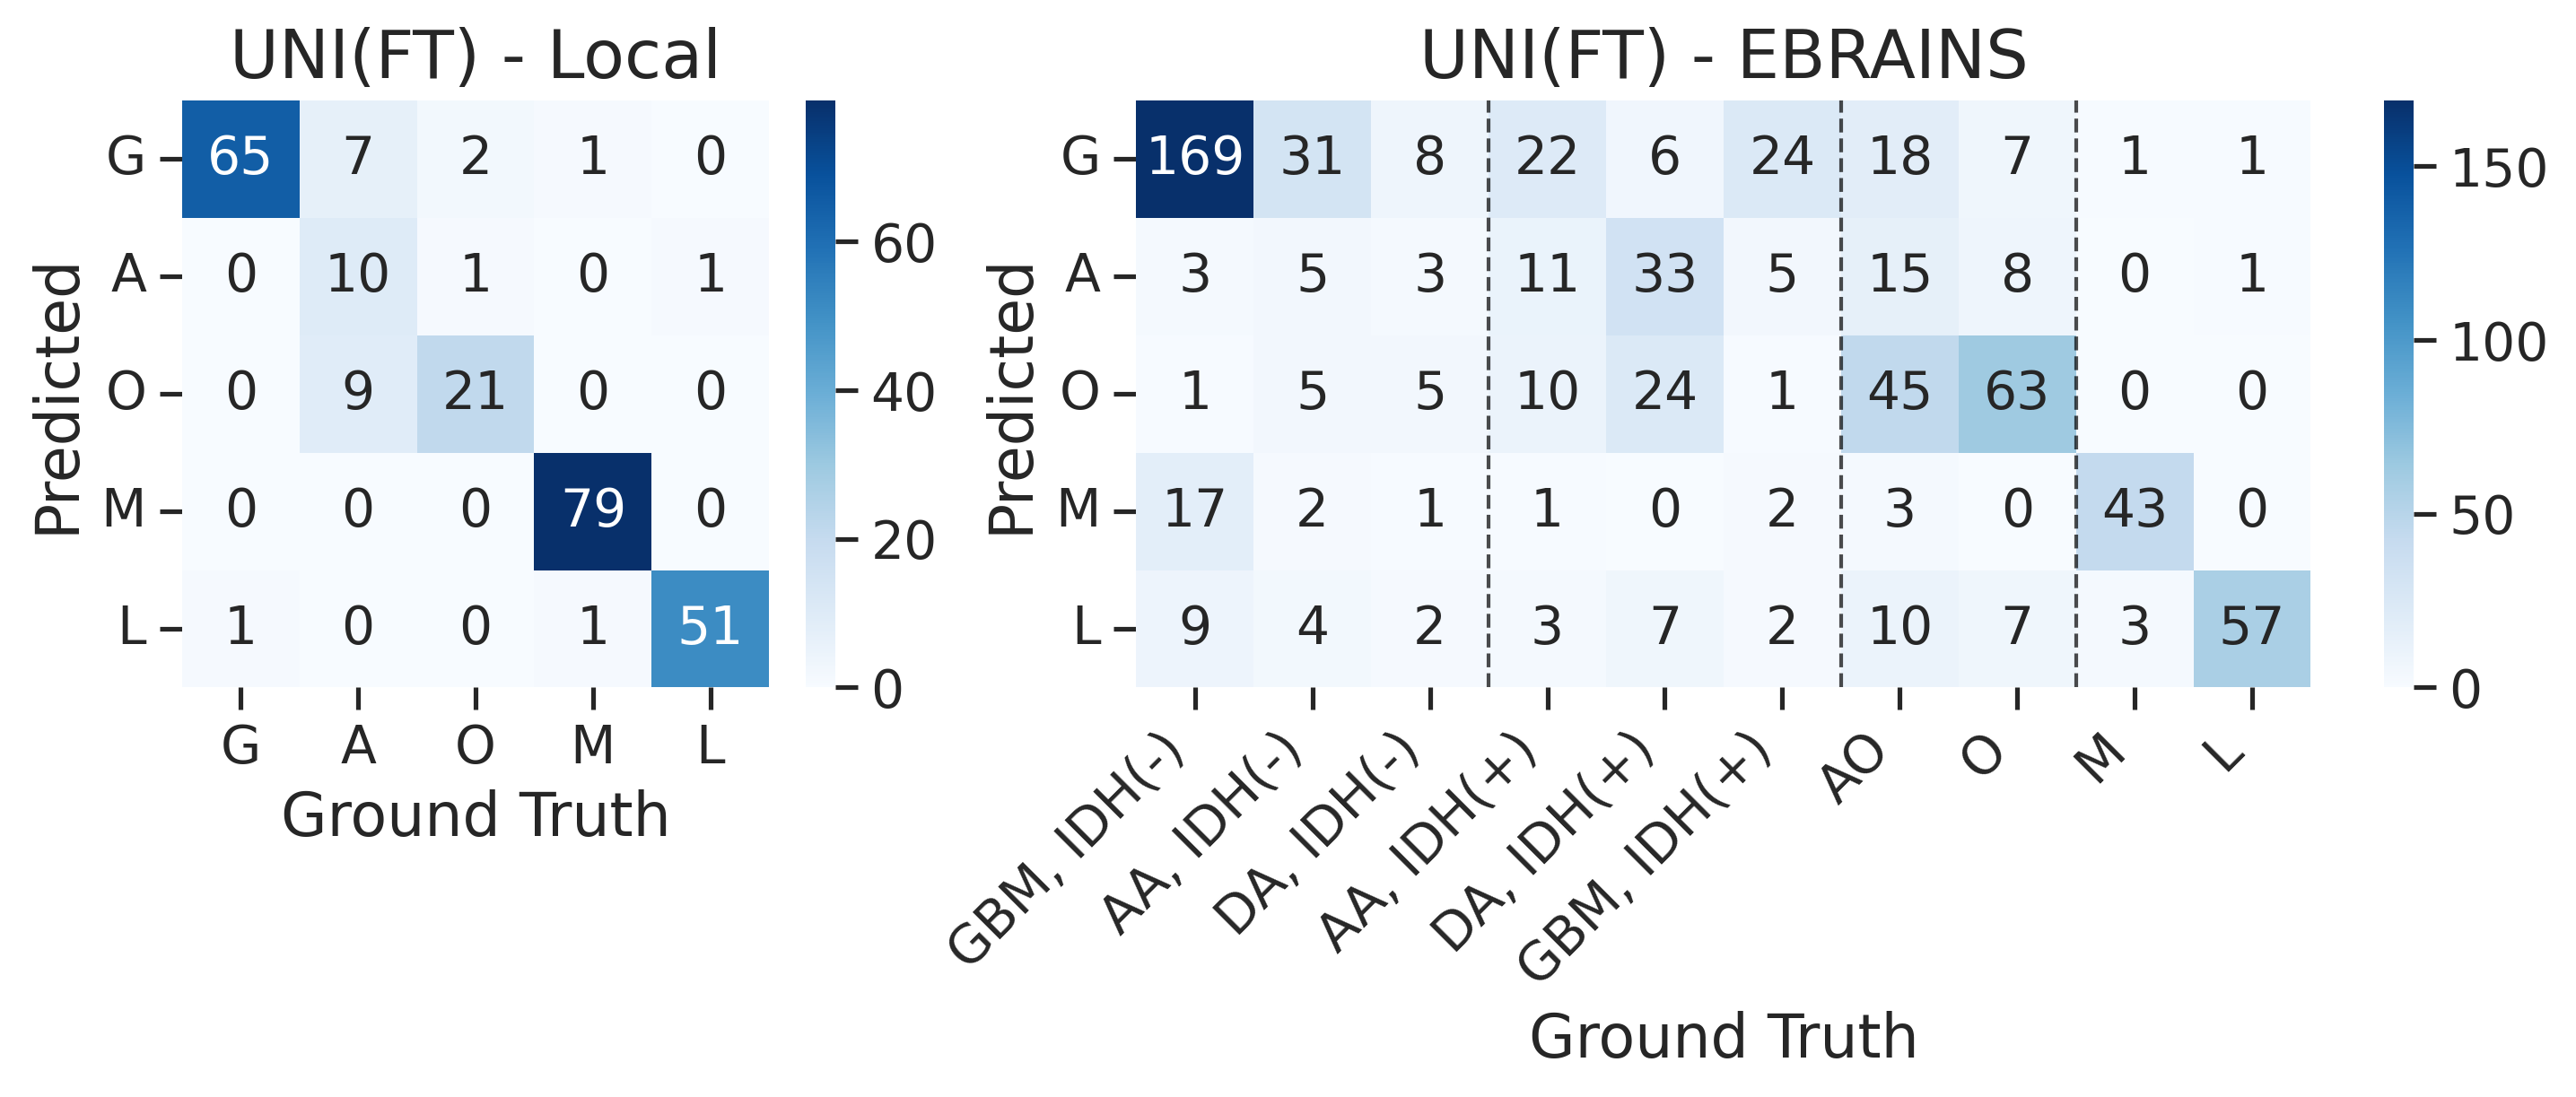

In [5]:
draw_cm('uni', 'unfrozen')